In [109]:
import numpy as np
import pandas as pd

file_prefix = "california"  # Change this to any word you like

df =  pd.read_csv(f'Dataset/{file_prefix}.csv')
df.dropna(inplace=True)

In [111]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Identify categorical data (change this based on your actual data)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Apply Label Encoding to each categorical column
for column in categorical_cols:
    # Ensure the column is of type object (string) or category
    if df[column].dtype == 'object' or df[column].dtype.name == 'category':
        df[column] = le.fit_transform(df[column])
        


In [112]:
df

,Y,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
20046,47700.0,1.6812,25,1505,367,1392,359,36.06,-119.01,181940.136332,233893.527814,408714.566871,293550.331117,358894.994747
3024,45800.0,2.5313,30,2943,697,1565,584,35.14,-119.46,81381.242991,164389.284615,342981.620308,327407.281369,395422.046998
15663,500001.0,3.4801,52,3830,1142,1310,963,37.80,-122.44,540.917690,562389.565893,740893.792262,70653.801257,2993.525022
20484,218600.0,5.7376,17,3051,505,1705,495,34.28,-118.72,29434.721926,50615.002818,226155.681336,444127.558426,512081.027489
9814,278000.0,3.7250,34,2351,440,1063,428,36.62,-121.93,5392.746480,439632.446326,615200.335195,79625.503189,135780.250676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,228100.0,2.9899,52,2097,444,915,413,37.77,-122.26,3888.486691,549175.330718,727927.591997,58146.360377,15062.545638
13089,126900.0,5.0427,22,2607,411,1216,407,38.55,-121.35,57031.222736,572282.338871,750897.416856,143197.022871,127994.956182
12824,135500.0,4.7396,25,1287,224,727,236,38.73,-121.44,73639.606234,593529.764760,772054.137395,160058.779068,137087.835093
9097,156700.0,5.0839,25,3080,587,1558,510,34.73,-118.61,77286.014706,82519.751930,260992.562280,413569.314804,481550.668454


In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer, CopulaGANSynthesizer, GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import NearestNeighbors

# Function to create metadata
def create_metadata(data):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data)
    return metadata

# Data generation functions
def generate_data_ctgan(train_data, metadata):
    """Generate synthetic data using CTGANSynthesizer."""
    ctgan = CTGANSynthesizer(metadata)
    ctgan.fit(train_data)
    return ctgan.sample(num_rows=len(train_data))

def generate_data_tvae(train_data, metadata):
    """Generate synthetic data using TVAESynthesizer."""
    tvae = TVAESynthesizer(metadata)
    tvae.fit(train_data)
    return tvae.sample(num_rows=len(train_data))

def generate_data_copulagan(train_data, metadata):
    """Generate synthetic data using CopulaGANSynthesizer."""
    copulagan = CopulaGANSynthesizer(metadata)
    copulagan.fit(train_data)
    return copulagan.sample(num_rows=len(train_data))

def generate_data_gaussian_copula(train_data, metadata):
    """Generate synthetic data using GaussianCopulaSynthesizer."""
    gaussian_copula = GaussianCopulaSynthesizer(metadata)
    gaussian_copula.fit(train_data)
    return gaussian_copula.sample(num_rows=len(train_data))

def generate_data_regression(X, y, n_samples=None):
    """Generate synthetic data for regression using interpolation."""
    if n_samples is None:
        n_samples = len(X)
    
    # Convert to numpy arrays if they're not already
    X_array = X.values if hasattr(X, 'values') else X
    y_array = y.values if hasattr(y, 'values') else y
    
    # Combine features and target
    data = np.column_stack((X_array, y_array.reshape(-1, 1)))
    
    # Find nearest neighbors
    nn = NearestNeighbors(n_neighbors=2, metric='euclidean')
    nn.fit(data)
    
    synthetic_data = []
    
    for _ in range(n_samples):
        # Randomly select a sample
        idx = np.random.randint(0, len(data))
        sample = data[idx]
        
        # Find its nearest neighbor
        _, indices = nn.kneighbors([sample], n_neighbors=2)
        nn_idx = indices[0][1]  # Index of the nearest neighbor (excluding itself)
        
        # Interpolate between the sample and its nearest neighbor
        alpha = np.random.random()
        synthetic_sample = sample + alpha * (data[nn_idx] - sample)
        
        synthetic_data.append(synthetic_sample)
    
    synthetic_data = np.array(synthetic_data)
    X_synthetic = synthetic_data[:, :-1]
    y_synthetic = synthetic_data[:, -1]
    
    # If original X was a DataFrame, use its column names
    if hasattr(X, 'columns'):
        X_synthetic = pd.DataFrame(X_synthetic, columns=X.columns)
    
    return X_synthetic, pd.Series(y_synthetic, name='Y')

def generate_data_regression_wrapper(X, y):
    X_synthetic, y_synthetic = generate_data_regression(X, y)
    return pd.concat([X_synthetic, y_synthetic], axis=1)

def generate_data_decision_tree(train_data):
    """Generate synthetic data using Decision Tree."""
    X = train_data.drop('Y', axis=1)
    y = train_data['Y']
    
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X, y)
    
    synthetic_X = pd.DataFrame(columns=X.columns)
    synthetic_y = []
    
    for _ in range(len(train_data)):
        sample = X.sample(n=1, replace=True)
        synthetic_sample = sample.copy()
        
        for feature in X.columns:
            if np.random.rand() < 0.5:  # 50% chance to modify each feature
                feature_min = X[feature].min()
                feature_max = X[feature].max()
                synthetic_sample[feature] = np.random.uniform(feature_min, feature_max)
        
        synthetic_X = pd.concat([synthetic_X, synthetic_sample])
        synthetic_y.append(dt.predict(synthetic_sample)[0])
    
    synthetic_X = synthetic_X.reset_index(drop=True)
    synthetic_y = pd.Series(synthetic_y, name='Y')
    
    synthetic_data = pd.concat([synthetic_X, synthetic_y], axis=1)
    return synthetic_data

def generate_data_stochastic(train_data, n_samples):
    """Generate synthetic data using a simple stochastic process."""
    synthetic_data = []
    
    # Calculate mean and standard deviation for each column
    column_stats = train_data.agg(['mean', 'std'])
    
    for _ in range(n_samples):
        row = {}
        for column in train_data.columns:
            if train_data[column].dtype in ['int64', 'float64']:
                # For numerical columns, use a random walk
                mean = column_stats.loc['mean', column]
                std = column_stats.loc['std', column]
                row[column] = np.random.normal(mean, std)
            else:
                # For categorical columns, use the empirical distribution
                row[column] = np.random.choice(train_data[column])
        
        synthetic_data.append(row)
    
    return pd.DataFrame(synthetic_data)

# Load and prepare data

X = df.drop('Y', axis=1)
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = pd.concat([X_train, y_train], axis=1)

# Create metadata
metadata = create_metadata(train_data)

# Generate synthetic data
print("Generating synthetic data...")
synthetic_data_ctgan = generate_data_ctgan(train_data, metadata)
synthetic_data_tvae = generate_data_tvae(train_data, metadata)
synthetic_data_copulagan = generate_data_copulagan(train_data, metadata)
synthetic_data_gaussian_copula = generate_data_gaussian_copula(train_data, metadata)
synthetic_data_regression = generate_data_regression_wrapper(X_train, y_train)
synthetic_data_decision_tree = generate_data_decision_tree(train_data)
synthetic_data_stochastic = generate_data_stochastic(train_data, len(train_data))
print("Synthetic data generation complete.")

# Save synthetic data to CSV files
synthetic_data_ctgan.to_csv('synthetic_data_ctgan.csv', index=False)
synthetic_data_tvae.to_csv('synthetic_data_tvae.csv', index=False)
synthetic_data_copulagan.to_csv('synthetic_data_copulagan.csv', index=False)
synthetic_data_gaussian_copula.to_csv('synthetic_data_gaussian_copula.csv', index=False)
synthetic_data_regression.to_csv('synthetic_data_regression.csv', index=False)
synthetic_data_decision_tree.to_csv('synthetic_data_decision_tree.csv', index=False)
synthetic_data_stochastic.to_csv('synthetic_data_stochastic.csv', index=False)

print("Synthetic data saved to CSV files.")

Generating synthetic data...


c:\Users\Tommy\anaconda3\Lib\site-packages\sdv\single_table\base.py:92: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Synthetic data generation complete.
Synthetic data saved to CSV files.


Evaluating Linear Regression on original data...
Evaluating Linear Regression on CTGAN synthetic data...
Evaluating Linear Regression on TVAE synthetic data...
Evaluating Linear Regression on CopulaGAN synthetic data...
Evaluating Linear Regression on GaussianCopula synthetic data...
Evaluating Linear Regression on Regression synthetic data...
Evaluating Linear Regression on DecisionTree synthetic data...
Evaluating Linear Regression on Stochastic synthetic data...
Evaluating KNN on original data...
Evaluating KNN on CTGAN synthetic data...
Evaluating KNN on TVAE synthetic data...
Evaluating KNN on CopulaGAN synthetic data...
Evaluating KNN on GaussianCopula synthetic data...
Evaluating KNN on Regression synthetic data...
Evaluating KNN on DecisionTree synthetic data...
Evaluating KNN on Stochastic synthetic data...
Evaluating Decision Tree on original data...
Evaluating Decision Tree on CTGAN synthetic data...
Evaluating Decision Tree on TVAE synthetic data...
Evaluating Decision Tree

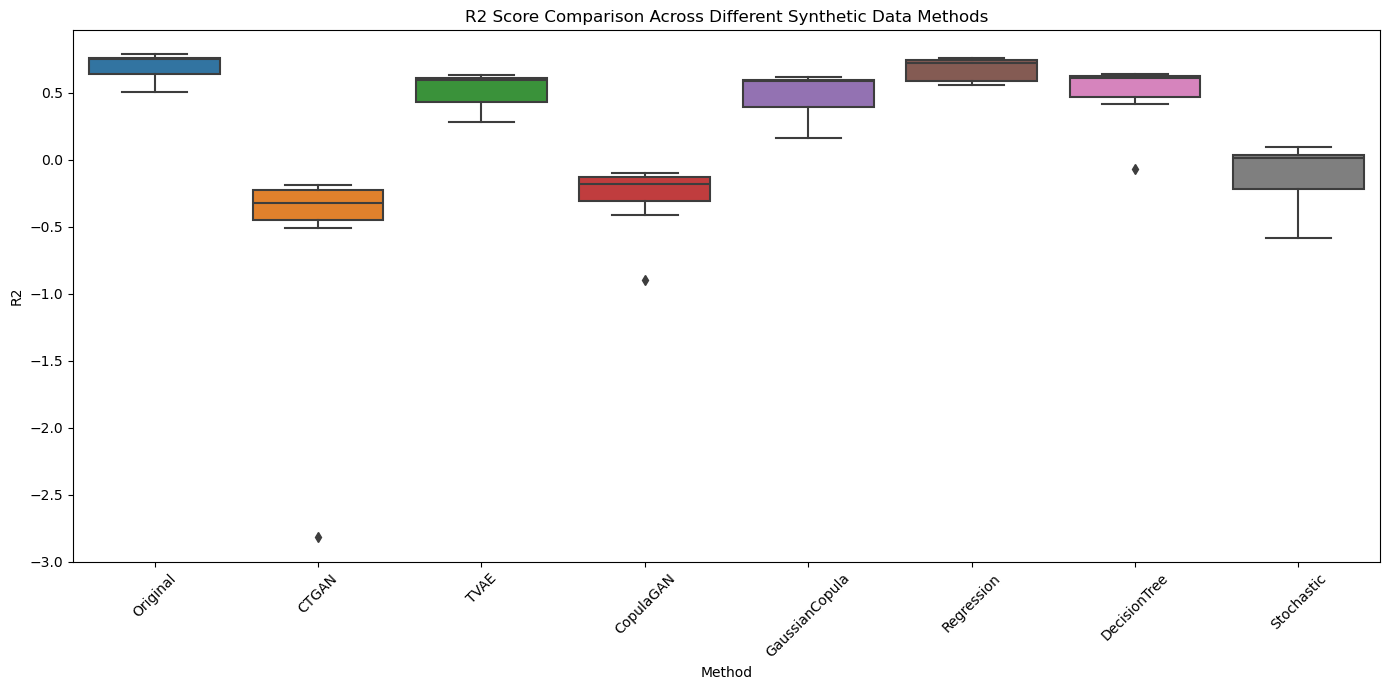

<Figure size 1200x600 with 0 Axes>

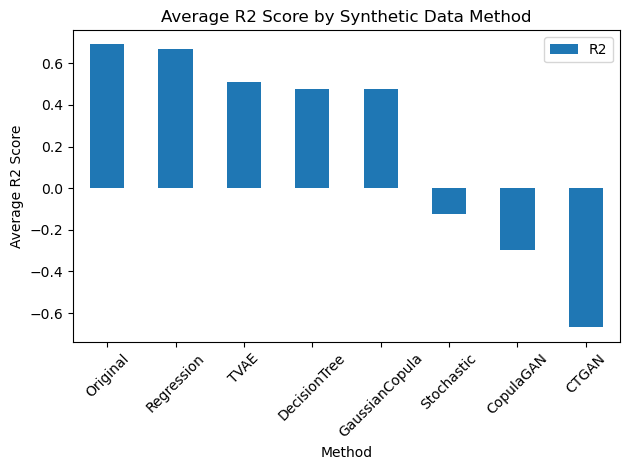

In [114]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# Regressor evaluation function with cross-validation
def evaluate_regressor(reg, X_train, y_train, X_test, y_test, cv=5):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        
        reg.fit(X_train_cv, y_train_cv)
        y_val_pred = reg.predict(X_val_cv)
        mse_scores.append(mean_squared_error(y_val_cv, y_val_pred))
    
    cv_mean = np.mean(mse_scores)
    cv_std = np.std(mse_scores)
    
    return mse, r2, cv_mean, cv_std

# Load synthetic data
def load_synthetic_data(file_path):
    synthetic_data = pd.read_csv(file_path)
    X_synthetic = synthetic_data.drop('Y', axis=1)
    y_synthetic = synthetic_data['Y']
    return X_synthetic, y_synthetic

# List of synthetic data files
synthetic_files = {
    'CTGAN': 'synthetic_data_ctgan.csv',
    'TVAE': 'synthetic_data_tvae.csv',
    'CopulaGAN': 'synthetic_data_copulagan.csv',
    'GaussianCopula': 'synthetic_data_gaussian_copula.csv',
    'Regression': 'synthetic_data_regression.csv',
    'DecisionTree': 'synthetic_data_decision_tree.csv',
    'Stochastic': 'synthetic_data_stochastic.csv'
}

# Load synthetic data
synthetic_data = {method: load_synthetic_data(file) for method, file in synthetic_files.items()}

# Regressor factory functions
def get_regressors():
    return {
        "Linear Regression": LinearRegression(),
        "KNN": KNeighborsRegressor(),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(random_state=42),
        "LightGBM": lgb.LGBMRegressor(random_state=42),
    }

# Ensure X_train, y_train, X_test, y_test are defined
original_data = df
X = original_data.drop('Y', axis=1)
y = original_data['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate regressors on synthetic data and original data
results = []
for name, reg in get_regressors().items():
    print(f"Evaluating {name} on original data...")
    # Evaluate on original data
    mse, r2, cv_mean, cv_std = evaluate_regressor(reg, X_train, y_train, X_test, y_test)
    results.append({'Method': 'Original', 'Regressor': name, 'MSE': mse, 'R2': r2, 'CV Mean': cv_mean, 'CV Std': cv_std})
    
    # Evaluate on synthetic data
    for method, (X_synthetic, y_synthetic) in synthetic_data.items():
        print(f"Evaluating {name} on {method} synthetic data...")
        reg = get_regressors()[name]  # Get a fresh instance of the regressor
        mse, r2, cv_mean, cv_std = evaluate_regressor(reg, X_synthetic, y_synthetic, X_test, y_test)
        results.append({'Method': method, 'Regressor': name, 'MSE': mse, 'R2': r2, 'CV Mean': cv_mean, 'CV Std': cv_std})

results_df = pd.DataFrame(results)

# Sort results for easier comparison
results_df_sorted = results_df.sort_values(['Regressor', 'Method'])

# Calculate average performance for each method
average_performance = results_df.groupby('Method')[['MSE', 'R2', 'CV Mean', 'CV Std']].mean().sort_values('R2', ascending=False)
print("\nAverage Performance by Method:")
print(average_performance)

# Visualize the results
plt.figure(figsize=(14, 7))
sns.boxplot(x='Method', y='R2', data=results_df)
plt.title('R2 Score Comparison Across Different Synthetic Data Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot of average performance
plt.figure(figsize=(12, 6))
average_performance[['R2']].plot(kind='bar')
plt.title('Average R2 Score by Synthetic Data Method')
plt.xlabel('Method')
plt.ylabel('Average R2 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [115]:

import os

# Add rank column to average_improvement
average_performance['Rank'] = average_performance['CV Mean'].rank(ascending=True, method='min')
average_performance = average_performance.sort_values('Rank')

# Save average_improvement as CSV
average_performance.to_csv(f'result/generation/regression/{file_prefix}_average.csv', index=True)

# Save comparison_df as CSV
results_df_sorted.to_csv(f'result/generation/regression/{file_prefix}_compared.csv', index=True)

